# We are importing all the required packages

In [1]:
import tensorflow as tf
import string
import requests
import numpy as np
import keras
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Embedding
from tensorflow.keras.preprocessing.sequence import pad_sequences
from keras import backend as K

# Now we are getting the data from the link below using requests which handles URL's

In [2]:
response = requests.get('https://www.gutenberg.org/files/98/98-0.txt')
data = response.text.split('\n')
data = data[108:]
data = " ".join(data)

# This is a clean function which helps remove all unnecessary data from text file

In [3]:
def clean_text(doc):
  tokens = doc.split()
  table = str.maketrans('', '', string.punctuation)
  tokens = [w.translate(table) for w in tokens]
  tokens = [word for word in tokens if word.isalpha()]
  tokens = [word.lower() for word in tokens]
  return tokens


# Now we are using that clean function to clean our data

In [4]:
tokens = clean_text(data)

# We are now setting the train length for the model to train on

In [5]:
train_len = 5+1
text_sequences = []
for i in range(train_len,len(tokens)):
    seq = tokens[i-train_len:i]
    text_sequences.append(seq)

# This part of the code is just for counting the no.of.unique words

In [6]:
sequences = {}
count = 1
for i in range(len(tokens)):
    if tokens[i] not in sequences:
        sequences[tokens[i]] = count
        count += 1

# Now we are converting this sequences to number format (tokenizing)

In [7]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(text_sequences)
sequences = tokenizer.texts_to_sequences(text_sequences)

# we are setting the vocabulary size and setting train inputs and targets

In [8]:
vocabulary_size = len(tokenizer.word_counts)+1

n_sequences = np.empty([len(sequences),train_len], dtype='int32')
for i in range(len(sequences)):
    n_sequences[i] = sequences[i]

train_inputs = n_sequences[:,:-1]
train_targets = n_sequences[:,-1]
train_targets = to_categorical(train_targets, num_classes=vocabulary_size)
seq_len = train_inputs.shape[1]

# This is the custom metrics functions for f1-score, recall and precision of model

In [9]:

def recall_m(train_inputs, train_targets):
    true_positives = K.sum(K.round(K.clip(train_inputs * train_targets, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(train_inputs, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def precision_m(train_inputs, train_targets):
    true_positives = K.sum(K.round(K.clip(train_inputs * train_targets, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(train_targets, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def f1_m(train_inputs, train_targets):
    precision = precision_m(train_inputs, train_targets)
    recall = recall_m(train_inputs, train_targets)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))


# Now we are building and training the model

In [10]:
model = Sequential()
model.add(Embedding(vocabulary_size, 50, input_length=seq_len))
model.add(LSTM(100, return_sequences=True))
model.add(LSTM(100))
model.add(Dense(100, activation='relu'))
model.add(Dense(vocabulary_size, activation='softmax'))
model.summary()
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy',f1_m,precision_m, recall_m])
history=model.fit(train_inputs,train_targets,batch_size=256,epochs=500,verbose=1).history
model.save("LSTM.h5")

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 5, 50)             533100    
_________________________________________________________________
lstm (LSTM)                  (None, 5, 100)            60400     
_________________________________________________________________
lstm_1 (LSTM)                (None, 100)               80400     
_________________________________________________________________
dense (Dense)                (None, 100)               10100     
_________________________________________________________________
dense_1 (Dense)              (None, 10662)             1076862   
Total params: 1,760,862
Trainable params: 1,760,862
Non-trainable params: 0
_________________________________________________________________
Epoch 1/500
516/516 [==============================] - 67s 131ms/step - loss: 6.8339 - accuracy: 0.0600 - f1_m: 

516/516 [==============================] - 71s 137ms/step - loss: 1.3017 - accuracy: 0.6926 - f1_m: 0.6977 - precision_m: 0.9250 - recall_m: 0.5606
Epoch 96/500
516/516 [==============================] - 70s 135ms/step - loss: 1.2808 - accuracy: 0.6982 - f1_m: 0.7039 - precision_m: 0.9280 - recall_m: 0.5675
Epoch 97/500
516/516 [==============================] - 67s 130ms/step - loss: 1.2658 - accuracy: 0.7001 - f1_m: 0.7072 - precision_m: 0.9283 - recall_m: 0.5718
Epoch 98/500
516/516 [==============================] - 70s 135ms/step - loss: 1.2563 - accuracy: 0.7026 - f1_m: 0.7083 - precision_m: 0.9273 - recall_m: 0.5735
Epoch 99/500
516/516 [==============================] - 70s 135ms/step - loss: 1.2466 - accuracy: 0.7054 - f1_m: 0.7112 - precision_m: 0.9263 - recall_m: 0.5778
Epoch 100/500
516/516 [==============================] - 73s 141ms/step - loss: 1.2299 - accuracy: 0.7082 - f1_m: 0.7154 - precision_m: 0.9284 - recall_m: 0.5825
Epoch 101/500
516/516 [=======================

516/516 [==============================] - 78s 150ms/step - loss: 0.5534 - accuracy: 0.8572 - f1_m: 0.8637 - precision_m: 0.9401 - recall_m: 0.7990 17s - loss:
Epoch 196/500
516/516 [==============================] - 77s 149ms/step - loss: 0.5492 - accuracy: 0.8582 - f1_m: 0.8650 - precision_m: 0.9395 - recall_m: 0.8017
Epoch 197/500
516/516 [==============================] - 78s 151ms/step - loss: 0.5549 - accuracy: 0.8559 - f1_m: 0.8626 - precision_m: 0.9377 - recall_m: 0.7989
Epoch 198/500
516/516 [==============================] - 79s 153ms/step - loss: 0.5527 - accuracy: 0.8563 - f1_m: 0.8627 - precision_m: 0.9368 - recall_m: 0.7996
Epoch 199/500
516/516 [==============================] - 78s 151ms/step - loss: 0.5459 - accuracy: 0.8586 - f1_m: 0.8657 - precision_m: 0.9396 - recall_m: 0.8029
Epoch 200/500
516/516 [==============================] - 79s 152ms/step - loss: 0.5290 - accuracy: 0.8628 - f1_m: 0.8689 - precision_m: 0.9411 - recall_m: 0.8073
Epoch 201/500
516/516 [=======

516/516 [==============================] - 76s 147ms/step - loss: 0.3306 - accuracy: 0.9080 - f1_m: 0.9110 - precision_m: 0.9457 - recall_m: 0.8790
Epoch 296/500
516/516 [==============================] - 74s 144ms/step - loss: 0.3541 - accuracy: 0.9007 - f1_m: 0.9046 - precision_m: 0.9401 - recall_m: 0.8717
Epoch 297/500
516/516 [==============================] - 74s 143ms/step - loss: 0.3305 - accuracy: 0.9087 - f1_m: 0.9118 - precision_m: 0.9461 - recall_m: 0.8800
Epoch 298/500
516/516 [==============================] - 74s 143ms/step - loss: 0.3323 - accuracy: 0.9079 - f1_m: 0.9117 - precision_m: 0.9461 - recall_m: 0.8798
Epoch 299/500
516/516 [==============================] - 75s 145ms/step - loss: 0.3145 - accuracy: 0.9138 - f1_m: 0.9170 - precision_m: 0.9505 - recall_m: 0.8859
Epoch 300/500
516/516 [==============================] - 73s 142ms/step - loss: 0.3161 - accuracy: 0.9123 - f1_m: 0.9154 - precision_m: 0.9490 - recall_m: 0.8843
Epoch 301/500
516/516 [===================

516/516 [==============================] - 60s 116ms/step - loss: 0.2273 - accuracy: 0.9352 - f1_m: 0.9366 - precision_m: 0.9560 - recall_m: 0.9181
Epoch 396/500
516/516 [==============================] - 59s 114ms/step - loss: 0.2396 - accuracy: 0.9307 - f1_m: 0.9324 - precision_m: 0.9521 - recall_m: 0.9135
Epoch 397/500
516/516 [==============================] - 59s 114ms/step - loss: 0.2428 - accuracy: 0.9292 - f1_m: 0.9310 - precision_m: 0.9510 - recall_m: 0.9119
Epoch 398/500
516/516 [==============================] - 59s 114ms/step - loss: 0.2490 - accuracy: 0.9270 - f1_m: 0.9292 - precision_m: 0.9495 - recall_m: 0.9098
Epoch 399/500
516/516 [==============================] - 63s 121ms/step - loss: 0.2334 - accuracy: 0.9332 - f1_m: 0.9351 - precision_m: 0.9546 - recall_m: 0.9165
Epoch 400/500
516/516 [==============================] - 59s 115ms/step - loss: 0.2272 - accuracy: 0.9359 - f1_m: 0.9369 - precision_m: 0.9559 - recall_m: 0.9188
Epoch 401/500
516/516 [===================

516/516 [==============================] - 59s 114ms/step - loss: 0.1968 - accuracy: 0.9421 - f1_m: 0.9433 - precision_m: 0.9567 - recall_m: 0.9303
Epoch 496/500
516/516 [==============================] - 60s 116ms/step - loss: 0.1842 - accuracy: 0.9463 - f1_m: 0.9473 - precision_m: 0.9601 - recall_m: 0.9348
Epoch 497/500
516/516 [==============================] - 58s 113ms/step - loss: 0.1989 - accuracy: 0.9417 - f1_m: 0.9429 - precision_m: 0.9563 - recall_m: 0.9300
Epoch 498/500
516/516 [==============================] - 59s 115ms/step - loss: 0.2047 - accuracy: 0.9409 - f1_m: 0.9419 - precision_m: 0.9554 - recall_m: 0.9289
Epoch 499/500
516/516 [==============================] - 59s 114ms/step - loss: 0.2052 - accuracy: 0.9390 - f1_m: 0.9400 - precision_m: 0.9538 - recall_m: 0.9267
Epoch 500/500
516/516 [==============================] - 62s 120ms/step - loss: 0.1940 - accuracy: 0.9439 - f1_m: 0.9448 - precision_m: 0.9580 - recall_m: 0.9321


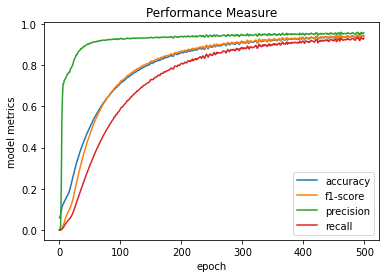

In [31]:
import matplotlib.pyplot as plt
plt.plot(history['accuracy'])
plt.plot(history['f1_m'])
plt.plot(history['precision_m'])
plt.plot(history['recall_m'])
plt.title('Performance Measure')
plt.ylabel('model metrics')
plt.xlabel('epoch')
plt.legend(['accuracy', 'f1-score','precision','recall'],loc='lower right')

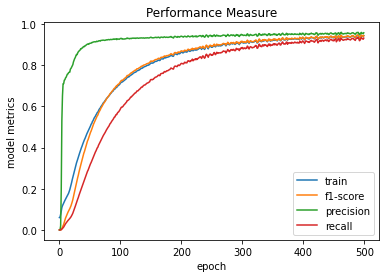

In [32]:
plt.plot(history['accuracy'])
plt.plot(history['f1_m'])
plt.plot(history['precision_m'])
plt.plot(history['recall_m'])
plt.title('Performance Measure')
plt.ylabel('model metrics')
plt.xlabel('epoch')
plt.legend(['train', 'f1-score','precision','recall'],loc='lower right')

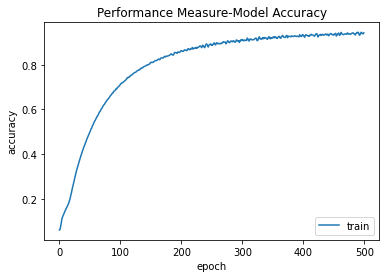

In [42]:
plt.plot(history['accuracy'])
plt.title('Performance Measure-Model Accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train'], loc='lower right')

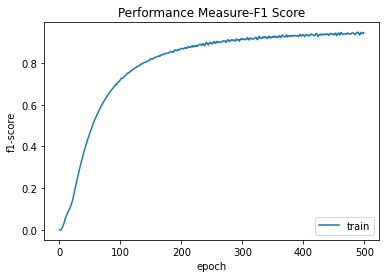

In [44]:
plt.plot(history['f1_m'])
plt.title('Performance Measure-F1 Score')
plt.ylabel('f1-score')
plt.xlabel('epoch')
plt.legend(['train'],loc='lower right')

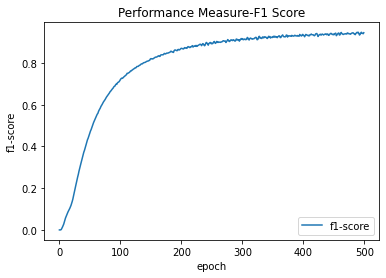

In [45]:
plt.plot(history['f1_m'])
plt.title('Performance Measure-F1 Score')
plt.ylabel('f1-score')
plt.xlabel('epoch')
plt.legend(['f1-score'],loc='lower right')

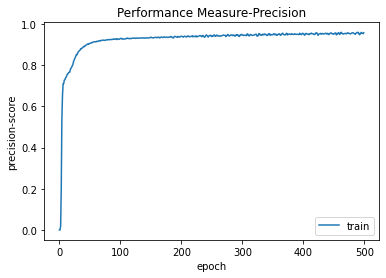

In [40]:
plt.plot(history['precision_m'])
plt.title('Performance Measure-Precision')
plt.ylabel('precision-score')
plt.xlabel('epoch')
plt.legend(['train'],loc='lower right')

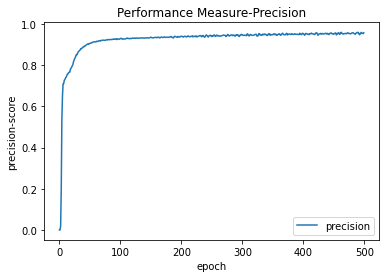

In [46]:
plt.plot(history['precision_m'])
plt.title('Performance Measure-Precision')
plt.ylabel('precision-score')
plt.xlabel('epoch')
plt.legend(['precision'],loc='lower right')

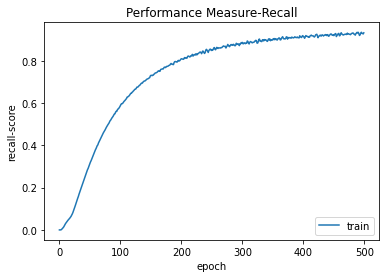

In [41]:
plt.plot(history['recall_m'])
plt.title('Performance Measure-Recall')
plt.ylabel('recall-score')
plt.xlabel('epoch')
plt.legend(['train'],loc='lower right')

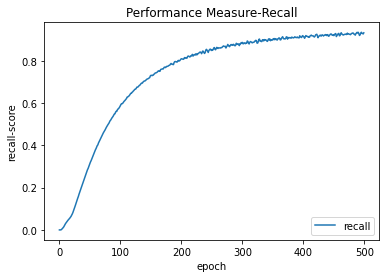

In [47]:
plt.plot(history['recall_m'])
plt.title('Performance Measure-Recall')
plt.ylabel('recall-score')
plt.xlabel('epoch')
plt.legend(['recall'],loc='lower right')

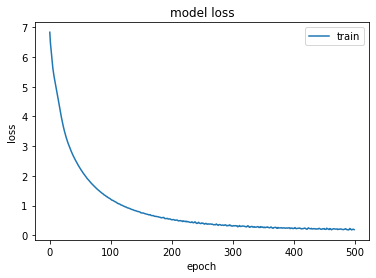

In [37]:
plt.plot(history['loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train'], loc='upper right')

# Now we use the model to give next word suggestions

In [13]:
input_text = input().strip().lower()
encoded_text = tokenizer.texts_to_sequences([input_text])[0]
pad_encoded = pad_sequences([encoded_text], maxlen=seq_len, truncating='pre')
print(encoded_text, pad_encoded)
for i in (model.predict(pad_encoded)[0]).argsort()[-3:][::-1]:
  pred_word = tokenizer.index_word[i]
  print("Next word suggestion:",pred_word)

what are you trying to
[58, 56, 15, 1049, 4] [[  58   56   15 1049    4]]
Next word suggestion: be
Next word suggestion: have
Next word suggestion: see
